In [4]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random

In [5]:
def init_nn_params(layer_widths, key):
    """
        Initialize the params and return them as a list of tuples of (weight, bias) pairs
    """
    params = []
    # for each sequential pair of layer widths
    for m, n in zip(layer_widths[:-1], layer_widths[1:]):
        # split key into two new keys
        key, subkey = jax.random.split(key)
        # Xavier initialization
        weight = jax.random.normal(subkey, (m, n)) / np.sqrt(m)
        bias = jnp.zeros(n)
        # append to the list 
        params.append((weight, bias))
    return params

def nn_forward(params, x):
    activations = x
    # hidden layers
    for w, b in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, w) + b)
    # output layer params
    final_w, final_b = params[-1]
    return jnp.dot(activations, final_w) + final_b

def loss_standard(params, t, observed_data, y0):
    """
    Args:
        params: parameters of the neural network
        t (array): array of time points at which to solve the ODE
        observed_data: observed data points (true solution of the ODE at time points t)
        y0: initial state of the system
    """
    def func(y, t):
        return nn_forward(params, y)
    
    # use "odeint" to solve the ODE given the current state of the system
    pred_solution = odeint(func, y0, t)
    return jnp.mean((pred_solution - observed_data) ** 2)


# train the neural ODE with ODE sovler approach
def train_nn_standard(params, t, observed_data, y0, lr=1e-3, num_epochs=1000):
    """
        params: Initial parameters of the neural network.
        t: Time points at which to solve the ODE.
        observed_data: Observed data points (true solution of the ODE).
        y0: Initial state of the system.
        lr: Learning rate for the optimizer (default is 0.001).
        num_epochs: Number of training epochs (default is 1000).
    """
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state):
        # loss function requires different params
        loss, grads = jax.value_and_grad(loss_standard)(params, t, observed_data, y0)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    for epoch in range(num_epochs):
        loss, params, opt_state = step(params, opt_state)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return params

layer_widths = [2, 100, 100, 2]

def train_model():
    params_standard = init_nn_params(layer_widths, jax.random.PRNGKey(0))
    trained_params_standard = train_nn_standard(params_standard, t, y, y0)

# solve the ODE using the neural network
def neural_ode(params, y0, t):
    def func(y, t):
        return nn_forward(params, y)
    # pass in the trained model as the derivative function
    return odeint(func, y0, t)

In [6]:
def harmonic_oscillator(state, t, omega_squared):
    x1, x2 = state
    dx1dt = x2
    dx2dt = -omega_squared * x1
    return jnp.array([dx1dt, dx2dt])

In [7]:
def plot_trajectory(t, true_solution, pred_solution, title):
    plt.figure(figsize=(10, 5))
    plt.plot(t, true_solution[:, 0], label='True X(t)', color='blue')
    plt.plot(t, true_solution[:, 1], label='True Y(t)', color='orange')
    plt.plot(t, pred_solution[:, 0], '--', label='Predicted X(t)', color='darkblue', alpha=0.6)
    plt.plot(t, pred_solution[:, 1], '--', label='Predicted Y(t)', color='orange', alpha=0.6)
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_phase_space(true_solution, pred_solution, title):
    plt.figure(figsize=(5, 5))
    plt.plot(true_solution[:, 0], true_solution[:, 1], label='True Trajectory', color='blue')
    plt.plot(pred_solution[:, 0], pred_solution[:, 1], '--', label='Predicted Trajectory', color='orange')
    plt.xlabel('X(t)')
    plt.ylabel('Y(t)')
    plt.title(title)
    plt.legend(loc='upper right')  # Position the legend in the upper right-hand corner
    plt.show()


In [8]:
#======================= Generate data for Damped Oscillator ======================= (NO NOISE)
n_points = 100
t = jnp.linspace(0, 10, n_points) # points at which to solve the ODE
y0 = jnp.array([1.0, 0.0]) # initial state
# solve the ODE
omega_squared = 1.0
y = odeint(harmonic_oscillator, y0, t, omega_squared)

In [9]:
%%time
# Initialize and train neural network for Damped Oscillator using Standard ODE Solver Approach
params_standard = init_nn_params(layer_widths, jax.random.PRNGKey(0))
trained_params_standard = train_nn_standard(params_standard, t, y, y0)

pred_solution_standard = neural_ode(trained_params_standard, y0, t)

Epoch 0, Loss: 16.054553985595703
Epoch 100, Loss: 0.4751656949520111
Epoch 200, Loss: 0.4696581959724426
Epoch 300, Loss: 0.46283507347106934
Epoch 400, Loss: 0.45392662286758423
Epoch 500, Loss: 0.44113802909851074
Epoch 600, Loss: 0.4276261031627655
Epoch 700, Loss: 0.3744105398654938
Epoch 800, Loss: 0.45064014196395874
Epoch 900, Loss: 0.40387168526649475
CPU times: user 44.3 s, sys: 502 ms, total: 44.8 s
Wall time: 44.9 s


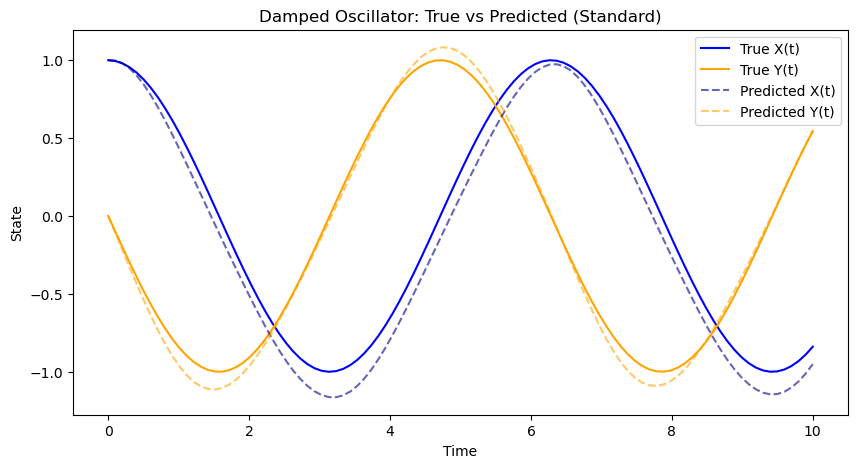

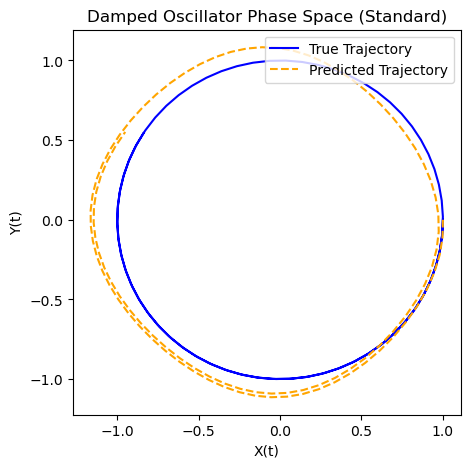

In [10]:
plot_trajectory(t, y, pred_solution_standard, 'Damped Oscillator: True vs Predicted (Standard)')
plot_phase_space(y, pred_solution_standard, 'Damped Oscillator Phase Space (Standard)')

### Define required Neural Network Function

In [11]:
class NeuralODE(nn.Module):
    layer_widths: list

    @nn.compact
    def __call__(self, x):
        for width in self.layer_widths[:-1]:
            x = nn.Dense(width)(x)
            x = nn.tanh(x)
        x = nn.Dense(self.layer_widths[-1])(x)
        return x
    
def create_train_state(rng, layer_widths, learning_rate):
    model = NeuralODE(layer_widths=layer_widths)
    params = model.init(rng, jnp.ones((2,)))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

    
def loss_fn(params, apply_fn, t, observed_data, y0):
    def func(y, t):
        return apply_fn({'params': params}, y)
    pred_solution = odeint(func, y0, t)
    return jnp.mean((pred_solution - observed_data)**2)

@jax.jit
def train_step(state, t, observed_data, y0):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, state.apply_fn, t, observed_data, y0)
    state = state.apply_gradients(grads=grads)
    return state, loss

def train(state, t, observed_data, y0, num_epochs=1000):
    for epoch in range(num_epochs):
        state, loss = train_step(state, t, observed_data, y0)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return state

### ODE

In [12]:
def harmonic_oscillator(state, t, omega_squared):
    x1, x2 = state
    dx1dt = x2
    dx2dt = -omega_squared * x1
    return jnp.array([dx1dt, dx2dt])

### Generate Data

In [16]:
n_points = 100
t = jnp.linspace(0, 10, n_points) # points at which to solve the ODE
y0 = jnp.array([1.0, 0.0]) # initial state
# solve the ODE
omega_squared = 4
y = odeint(harmonic_oscillator, y0, t, omega_squared)

noise = 0.1
y_noisy = y + noise * jax.random.normal(jax.random.PRNGKey(0), y.shape)

In [17]:
layer_widths = [2, 100, 100, 2]
rng = random.PRNGKey(0)
learning_rate = 1e-3

state = create_train_state(rng, layer_widths, learning_rate)
trained_state = train(state, t, y_noisy, y0, num_epochs = 300)

Epoch 0, Loss: 7.431212902069092
Epoch 100, Loss: 1.193373441696167
Epoch 200, Loss: 1.1440924406051636


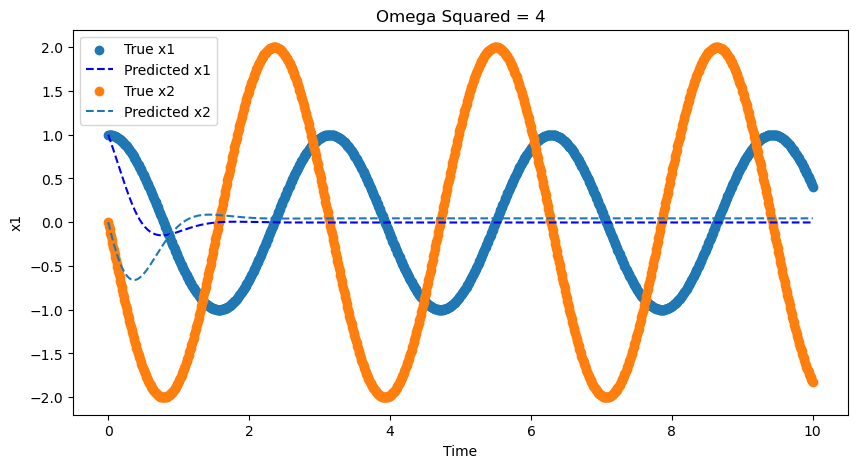

In [18]:
def neural_ode(params, y0, t):
    def func(y, t):
        return state.apply_fn({'params': params}, y)
    return odeint(func, y0, t)

y_pred = neural_ode(trained_state.params, y0, t)

plt.figure(figsize=(10, 5))
plt.scatter(t, y[:, 0], label='True x1')
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.scatter(t, y[:, 1], label='True x2')
plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {omega_squared}')
plt.show()


### Omega Squared 4.0, Noise 0.1

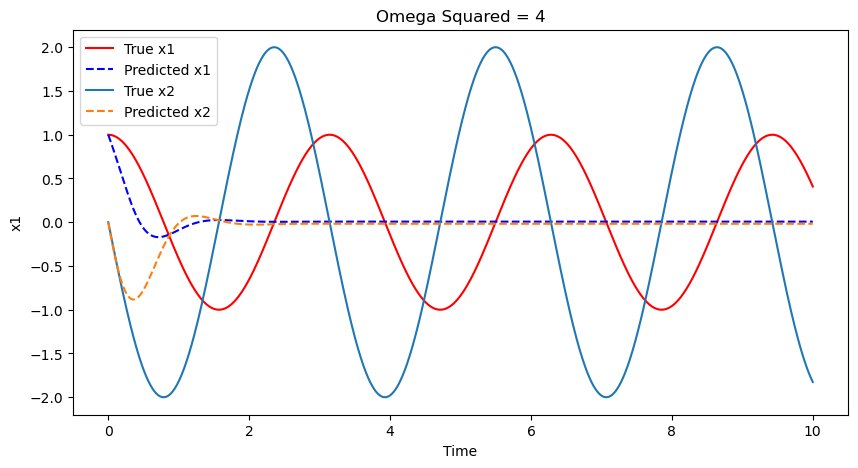

In [13]:
def neural_ode(params, y0, t):
    def func(y, t):
        return state.apply_fn({'params': params}, y)
    return odeint(func, y0, t)

y_pred = neural_ode(trained_state.params, y0, t)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t, y[:, 0], 'r-', label='True x1')
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.plot(t, y[:, 1], label='True x2')
plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {omega_squared}')
plt.show()


### Omega Squared 2.0, Noise 0.1

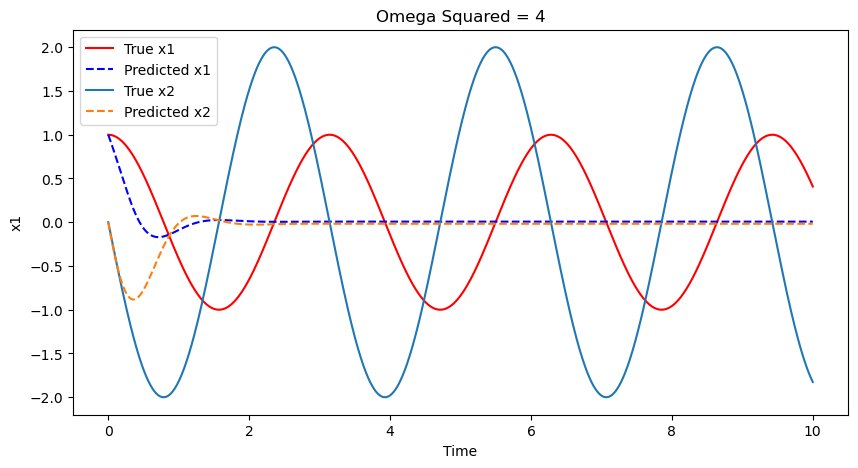

In [14]:
def neural_ode(params, y0, t):
    def func(y, t):
        return state.apply_fn({'params': params}, y)
    return odeint(func, y0, t)

y_pred = neural_ode(trained_state.params, y0, t)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t, y[:, 0], 'r-', label='True x1')
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.plot(t, y[:, 1], label='True x2')
plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {omega_squared}')
plt.show()


### Omega Squared 4.0, No noise

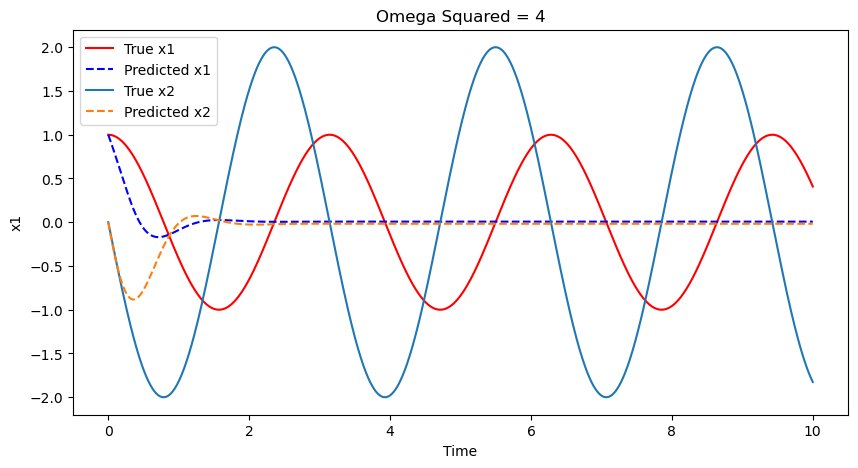

In [15]:
def neural_ode(params, y0, t):
    def func(y, t):
        return state.apply_fn({'params': params}, y)
    return odeint(func, y0, t)

y_pred = neural_ode(trained_state.params, y0, t)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t, y[:, 0], 'r-', label='True x1')
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.plot(t, y[:, 1], label='True x2')
plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {omega_squared}')
plt.show()


### Omega Squared 2.0, No noise

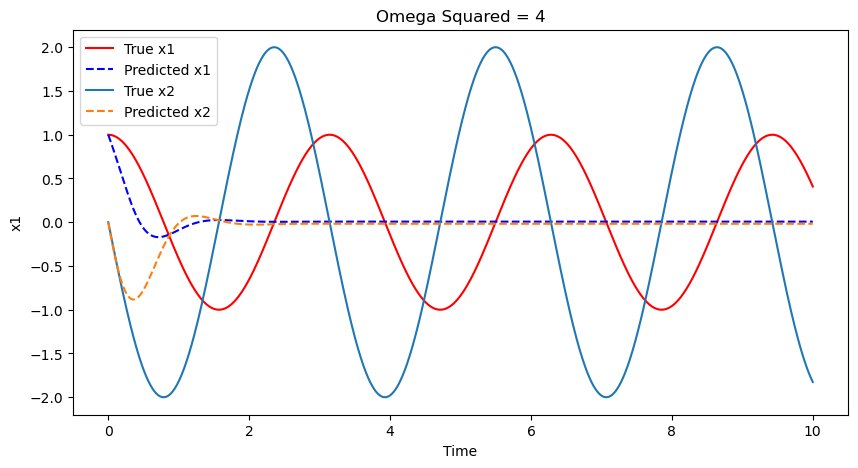

In [16]:
def neural_ode(params, y0, t):
    def func(y, t):
        return state.apply_fn({'params': params}, y)
    return odeint(func, y0, t)

y_pred = neural_ode(trained_state.params, y0, t)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t, y[:, 0], 'r-', label='True x1')
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.plot(t, y[:, 1], label='True x2')
plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {omega_squared}')
plt.show()
